In [41]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from IPython.display import Image, display

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

In [3]:
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [5]:
# Setting up file paths for training and testing
USER_PATH = r"D:/Code/brain_tumor/Data"
normal = USER_PATH + r'/'
tumor = USER_PATH + r'/Tumor'

# Getting data using above function
normal_paths, normal_labels = get_data_labels(normal, shuffle=False)
tumor_paths, tumor_labels = get_data_labels(tumor, shuffle=False)

# Printing Normal and tumor sample sizes
print('Normal Brain Scans')
print(f'Number of Paths: {len(normal_paths)}')
print(f'Number of Labels: {len(normal_labels)}')
print('\nTumor Brain Scans')
print(f'Number of Paths: {len(tumor_paths)}')
print(f'Number of Labels: {len(tumor_labels)}')

Normal Brain Scans
Number of Paths: 3069
Number of Labels: 3069

Tumor Brain Scans
Number of Paths: 18606
Number of Labels: 18606


In [10]:
tumor_labels = [path.replace('_tumor', '').title() for path in tumor_labels]
tumor_set = set(tumor_labels)
# Print the cleaned paths
print(f'Tumor labels: {tumor_set}')

Tumor labels: {'Pituitary', 'Meningioma', 'Glioma'}


In [11]:
from sklearn.model_selection import train_test_split
MRI_paths = normal_paths + tumor_paths
MRI_labels = normal_labels + tumor_labels
# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    MRI_paths, MRI_labels, test_size=0.35, random_state=SEED
)

# Create DataFrames for training and testing data
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

In [12]:
# 2 values in train_df and 1 in test_df have a un-defined tumor value
train_df = train_df[train_df['label'] != 'Tumor']
test_df = test_df[test_df['label'] != 'Tumor']

In [13]:
CLASS_TYPES = pd.unique(train_df['label'])
N_TYPES = len(CLASS_TYPES)

print(f'Classes: {CLASS_TYPES} and length {N_TYPES}')

Classes: ['Normal' 'Meningioma' 'Glioma' 'Pituitary'] and length 4


In [14]:
# Mapping dictionary
tumor_classes = {'Normal': 0,
                 'Glioma': 1,
                 'Meningioma': 2,
                 'Pituitary': 3
}


# Apply mapping to both DataFrames
train_df['label_encoded'] = train_df['label'].map(tumor_classes)
test_df['label_encoded'] = test_df['label'].map(tumor_classes)

In [15]:
print(train_df)

                                                    path       label  \
0           D:/Code/brain_tumor/Data/Normal\N_60_DA_.jpg      Normal   
1      D:/Code/brain_tumor/Data/Tumor\meningioma_tumo...  Meningioma   
2      D:/Code/brain_tumor/Data/Tumor\meningioma_tumo...  Meningioma   
3      D:/Code/brain_tumor/Data/Tumor\glioma_tumor\G_...      Glioma   
4      D:/Code/brain_tumor/Data/Tumor\glioma_tumor\G_...      Glioma   
...                                                  ...         ...   
14083  D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
14084  D:/Code/brain_tumor/Data/Tumor\meningioma_tumo...  Meningioma   
14085  D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
14086  D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
14087  D:/Code/brain_tumor/Data/Tumor\meningioma_tumo...  Meningioma   

       label_encoded  
0                  0  
1                  2  
2                  2  
3                  1  
4                  1

In [16]:
print(test_df)

                                                   path       label  \
0     D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
1     D:/Code/brain_tumor/Data/Tumor\glioma_tumor\G_...      Glioma   
2     D:/Code/brain_tumor/Data/Tumor\meningioma_tumo...  Meningioma   
3     D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
4     D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
...                                                 ...         ...   
7582  D:/Code/brain_tumor/Data/Tumor\glioma_tumor\G_...      Glioma   
7583  D:/Code/brain_tumor/Data/Tumor\meningioma_tumo...  Meningioma   
7584      D:/Code/brain_tumor/Data/Normal\N_176_DA_.jpg      Normal   
7585  D:/Code/brain_tumor/Data/Tumor\pituitary_tumor...   Pituitary   
7586  D:/Code/brain_tumor/Data/Tumor\glioma_tumor\G_...      Glioma   

      label_encoded  
0                 3  
1                 1  
2                 2  
3                 3  
4                 3  
...            

Training Counts
{'Normal': 2003, 'Meningioma': 4172, 'Glioma': 4059, 'Pituitary': 3852}

Testing Counts
{'Normal': 1063, 'Meningioma': 2219, 'Glioma': 2248, 'Pituitary': 2056}


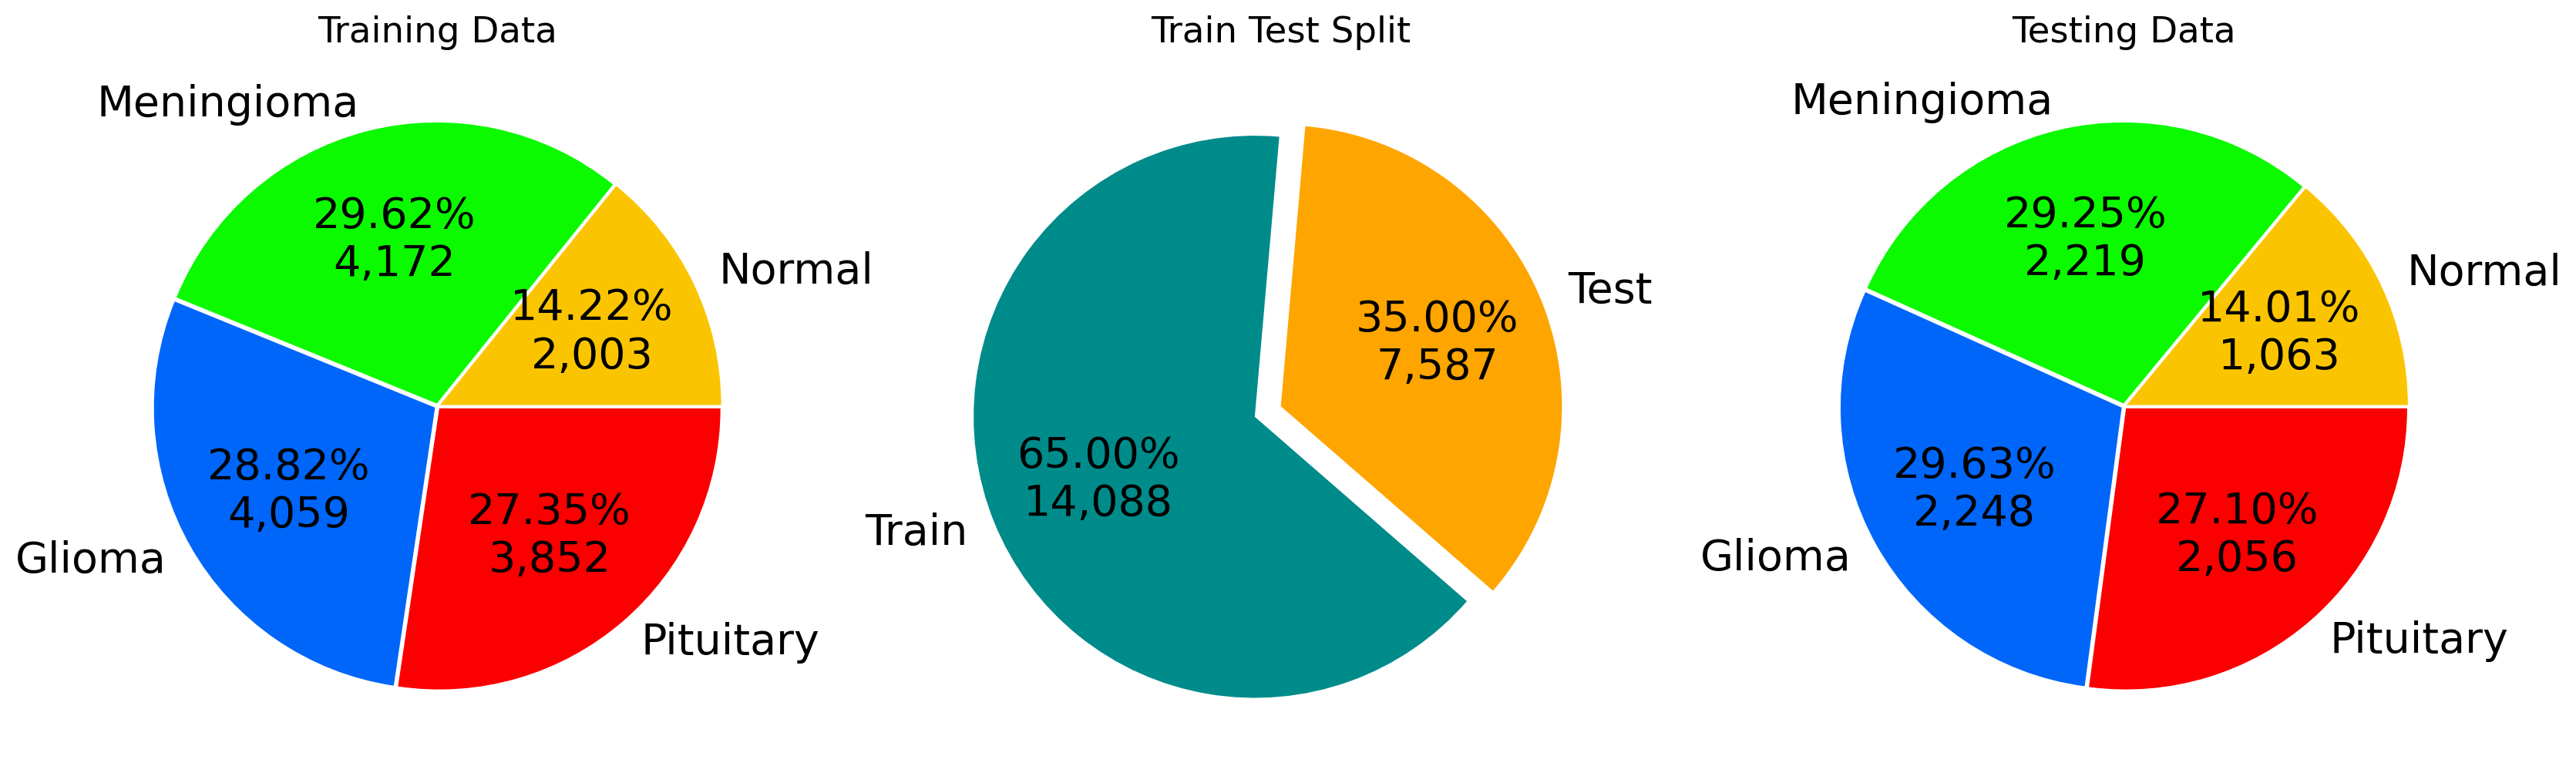

In [17]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=CLASS_TYPES,
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=CLASS_TYPES,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

x reshaped: (1, 150, 150, 3)


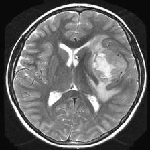

In [19]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [20]:
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

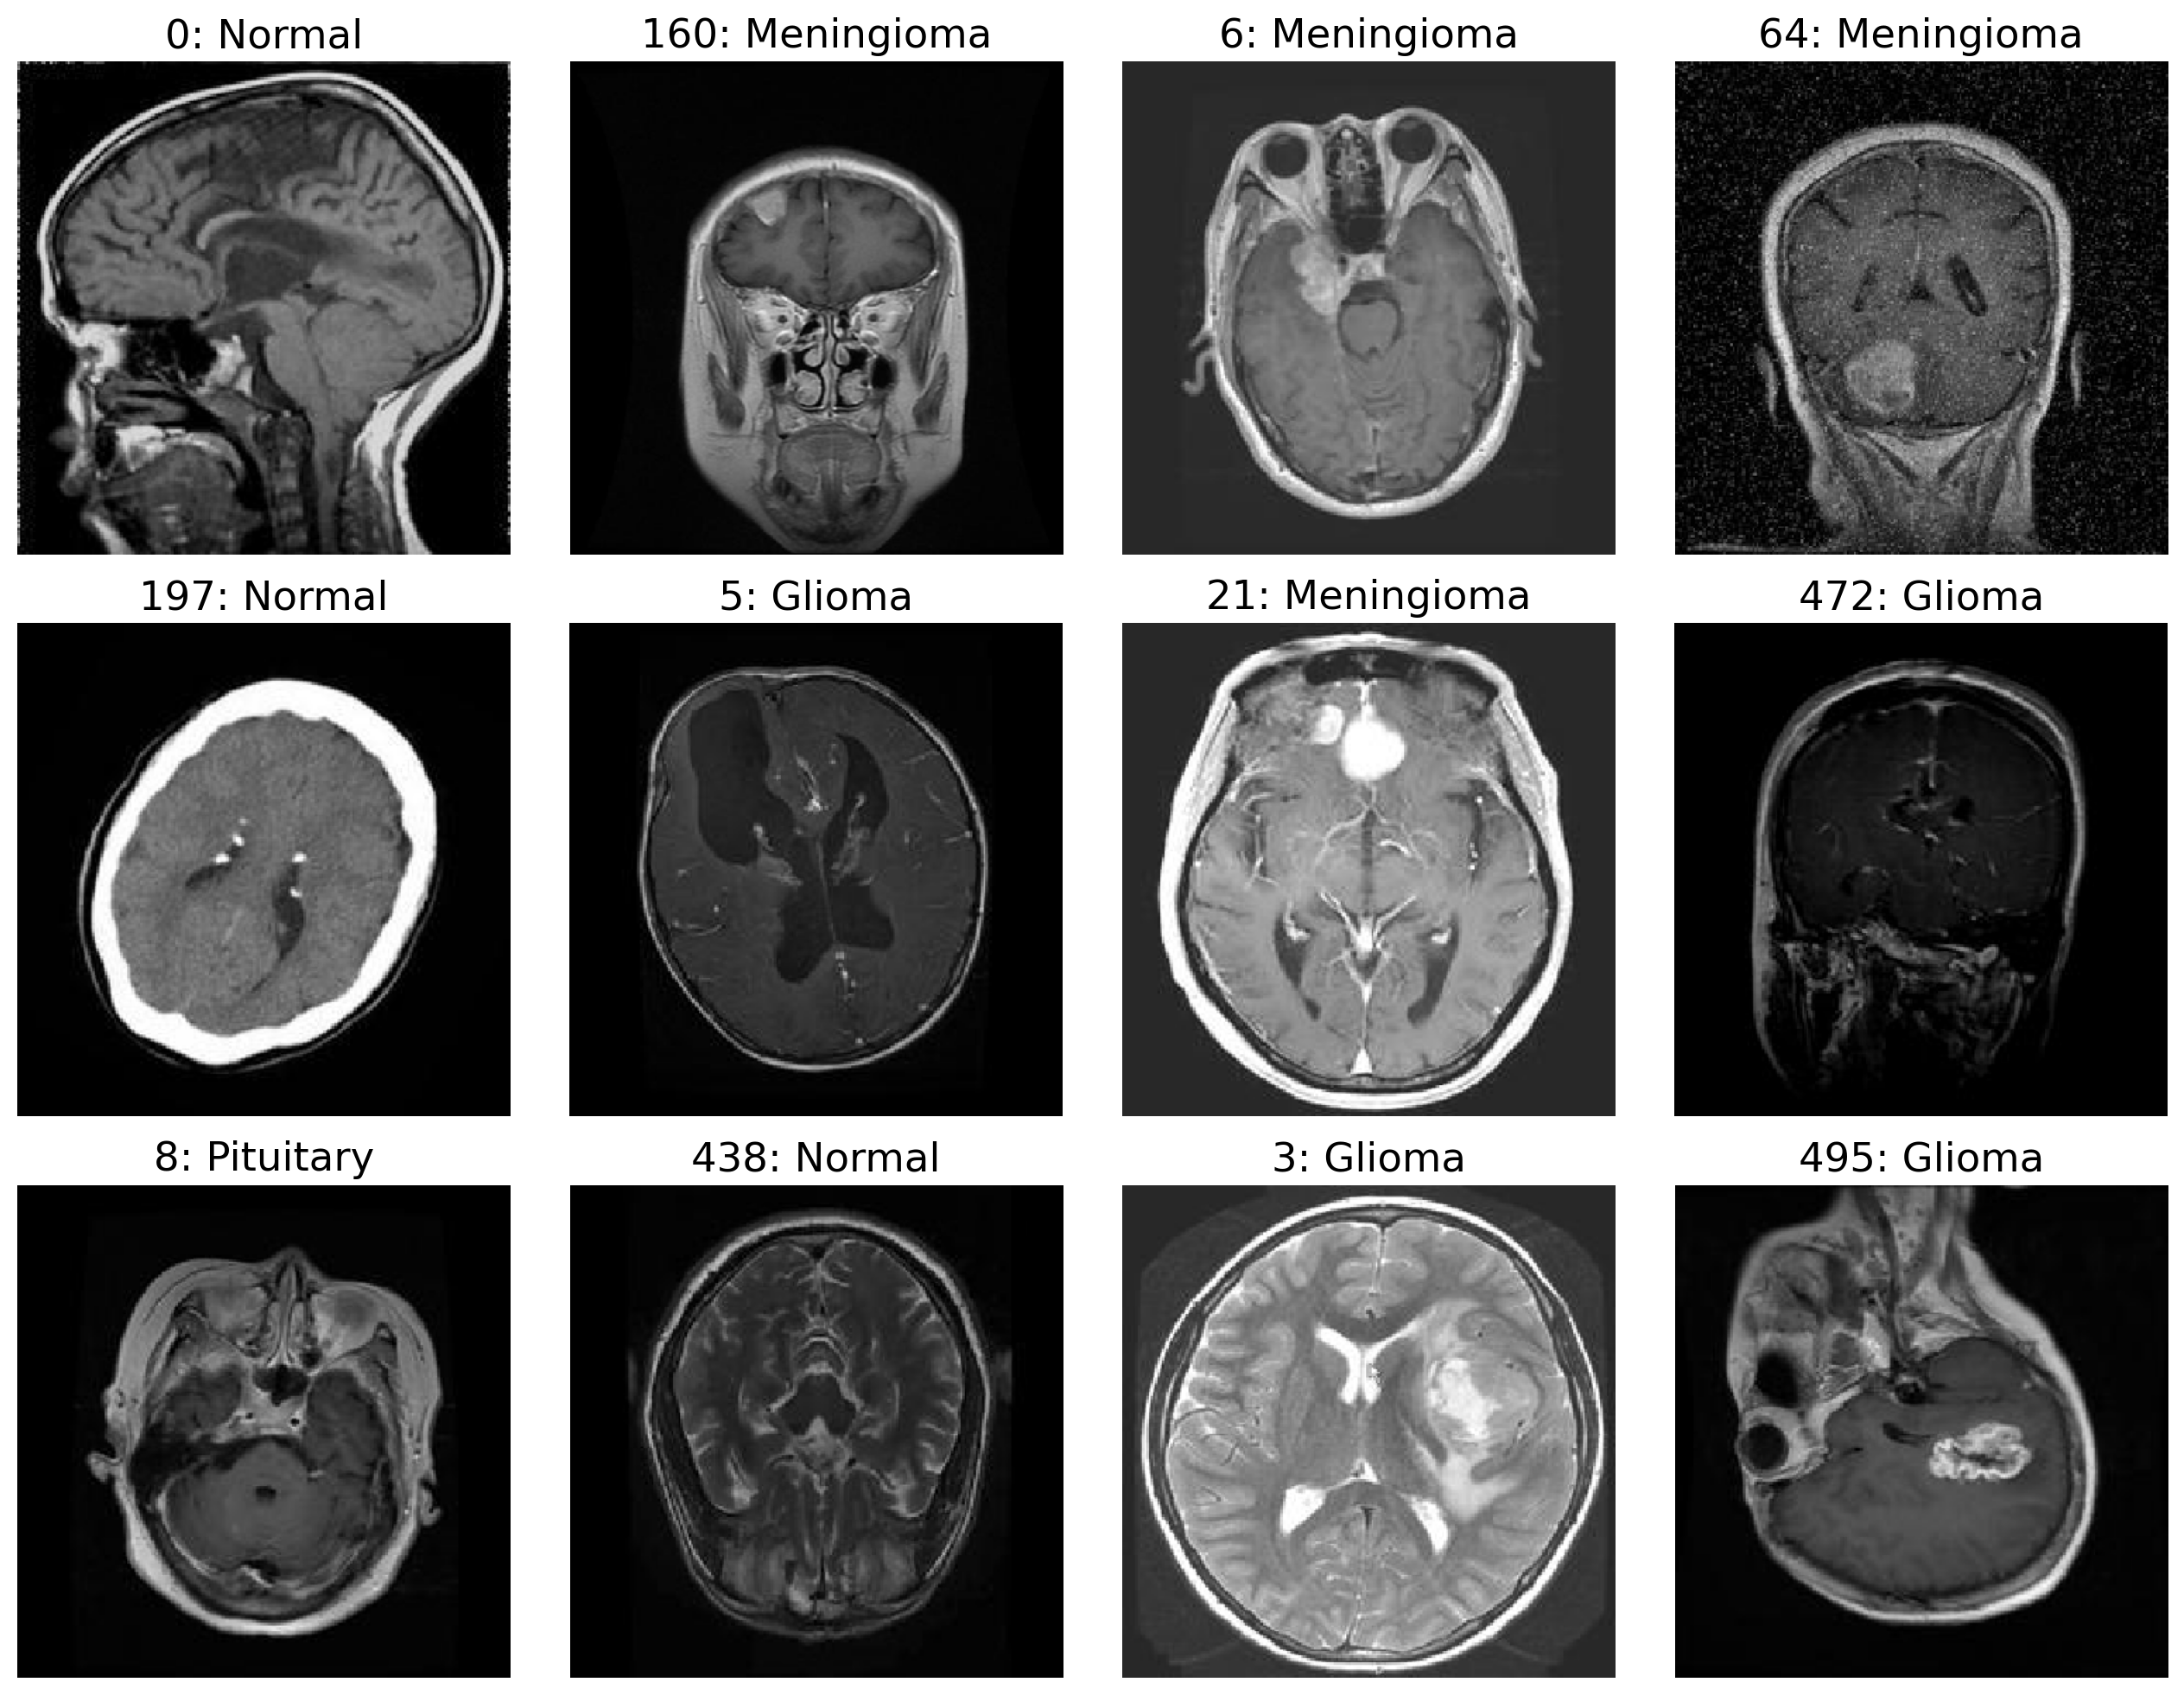

In [21]:
show_images(train_paths, 
            train_labels, 
            index_list=[0, 160, 6, 64,
                        197, 5, 21, 472,
                        8, 438, 3, 495], 
            im_size=350, 
            figsize=(13,10),
            save=SAVE)

In [22]:
image_size = (150, 150)
image_shape = (image_size[0], image_size[1], 1)

# Training parameters
epochs = 20
batch_size = 150

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

Image shape: (150, 150, 1)
Epochs: 20
Batch size: 150


In [23]:
def img_preprocessing(image_path, label_encoded):
    # Read and decode the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convert to grayscale
    img = tf.image.rgb_to_grayscale(img)
    
    # Resize and normalize the image
    img = tf.image.resize(img, size=(150, 150))
    img = img / 255.0
    
    return img, tf.one_hot(label_encoded, depth=N_TYPES)

# Creating dataset loaders with label indices
train_loader = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['label_encoded']))
train_dataset = (train_loader.map(img_preprocessing
                                 ).batch(batch_size).shuffle(train_df['path'].shape[0]).prefetch(batch_size))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['path'], test_df['label_encoded']))
test_dataset = (test_loader.map(img_preprocessing
                               ).batch(batch_size).shuffle(test_df['path'].shape[0]).prefetch(batch_size))

In [24]:
# Define the model architecture
model = models.Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3))) #

# Convolutional layer 4
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=SEED))
model.add(Dense(N_TYPES, activation="softmax"))

model.summary()


optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.87, beta_2=0.9995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [26]:
!pip install visualkeras

                                              0.0/43.2 kB ? eta -:--:--
     ---------------------------------------- 43.2/43.2 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


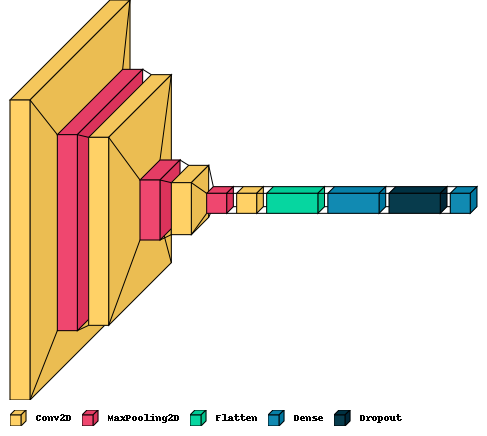

In [27]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [28]:
# addition of callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=6, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy')

# Training the model
history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=test_dataset,
                    callbacks=[model_es, model_rlr, model_cp])

Epoch 1/20
94/94 [==============================] - 59s 531ms/step - loss: 1.0424 - accuracy: 0.5382 - val_loss: 0.7772 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 2/20


C:\Users\athar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 50s 505ms/step - loss: 0.6893 - accuracy: 0.7197 - val_loss: 0.5860 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 50s 509ms/step - loss: 0.4844 - accuracy: 0.8111 - val_loss: 0.3892 - val_accuracy: 0.8626 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 51s 512ms/step - loss: 0.3287 - accuracy: 0.8760 - val_loss: 0.2935 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - 51s 512ms/step - loss: 0.2237 - accuracy: 0.9165 - val_loss: 0.2303 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - 51s 512ms/step - loss: 0.1608 - accuracy: 0.9415 - val_loss: 0.1858 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 7/20
94/94 [==============================] - 50s 508ms/step - loss: 0.1150 - accuracy: 0.9611 - val_loss: 0.2101 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 8/20
94/94 [==============================] - 51s 513ms/step - loss: 

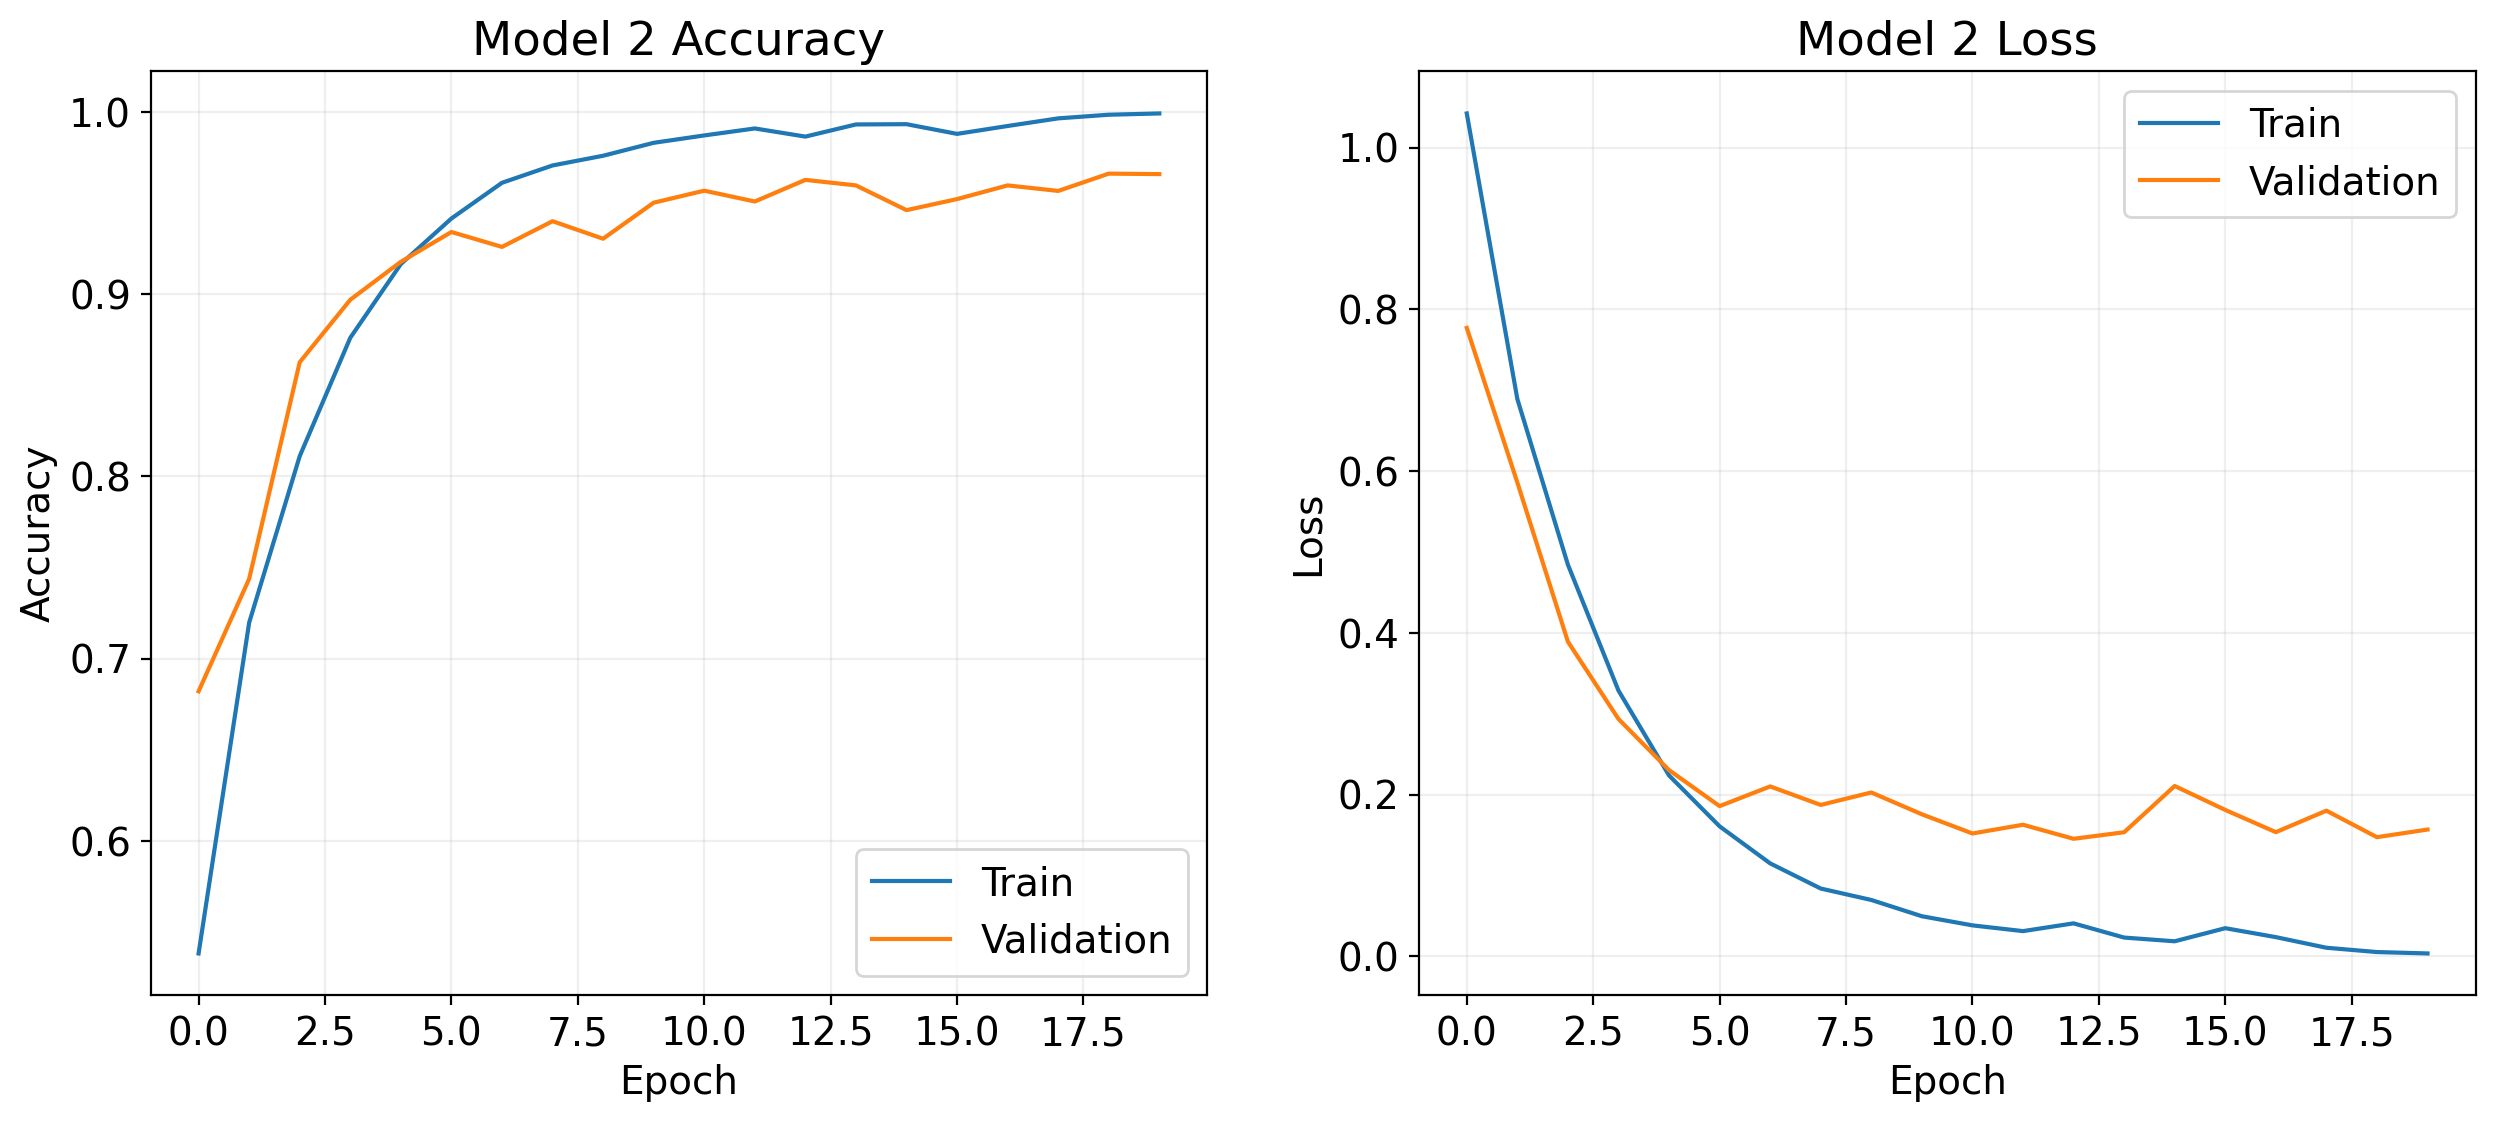

In [29]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [32]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\athar\best_weights.h5")

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

def generate_confusion_matrix(model, test_dataset, class_names):
    
    from sklearn.metrics import classification_report

    # Assuming test_dataset is a TensorFlow dataset
    true_labels = []
    predicted_labels = []

    for batch in test_dataset:
        images, labels = batch

        # Predict classes for the batch
        predictions = model.predict(images, verbose=False)
        predicted_classes = np.argmax(predictions, axis=1)

        # Convert one-hot encoded labels to class indices
        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print accuracy metrics using classification_report
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:\n", class_report)
    
    return cm

In [34]:
cm = generate_confusion_matrix(model, test_dataset, list(tumor_classes.keys()))

Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      1063
      Glioma       0.95      0.96      0.96      2248
  Meningioma       0.96      0.95      0.96      2219
   Pituitary       0.98      0.98      0.98      2056

    accuracy                           0.97      7586
   macro avg       0.97      0.97      0.97      7586
weighted avg       0.97      0.97      0.97      7586



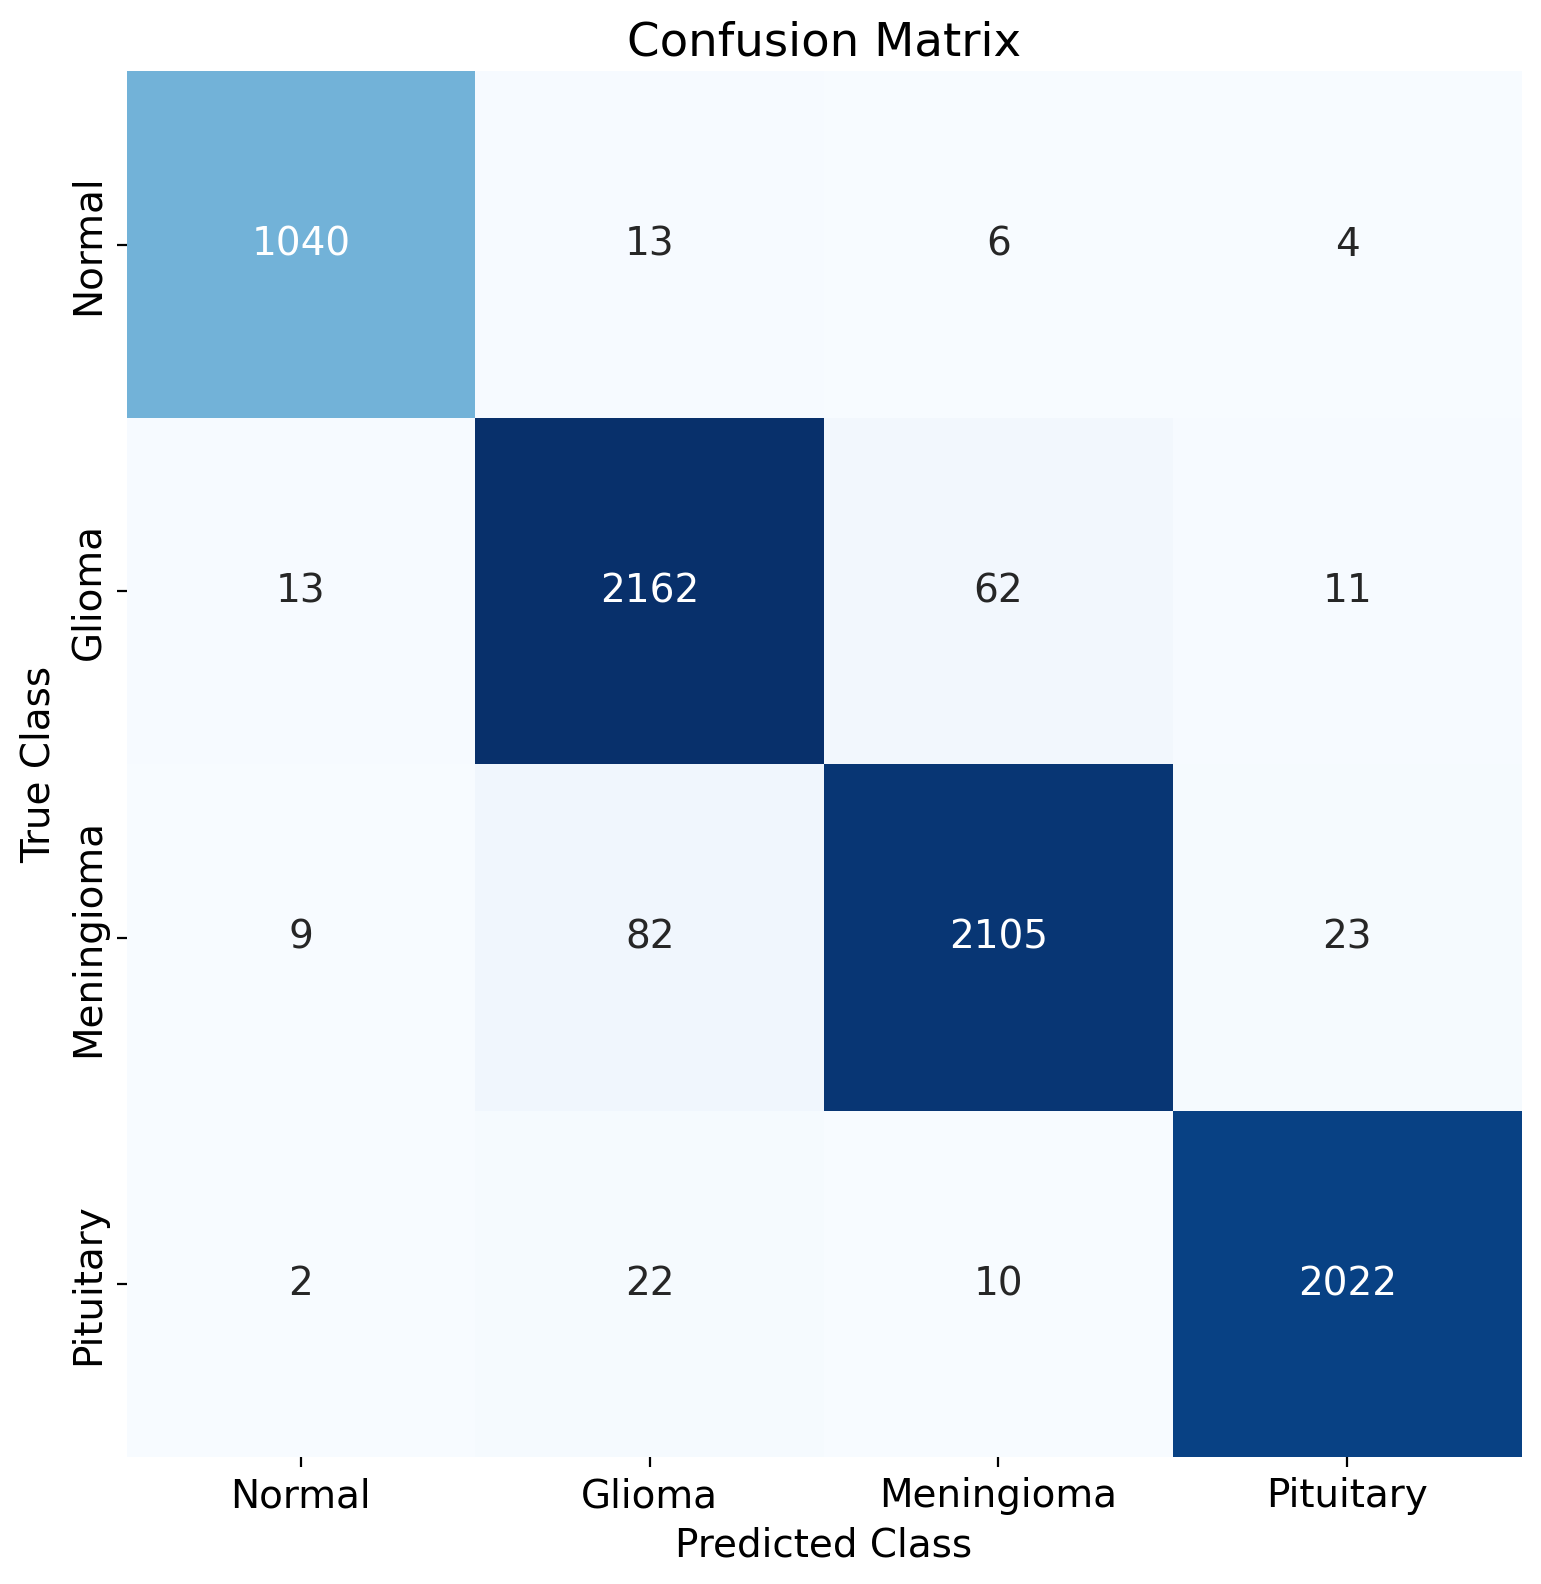

In [35]:
plot_confusion_matrix(cm, list(tumor_classes.keys()))

In [36]:
# channnel map plot
def plot_channel_activation_maps(model, image, images_per_row=16, N=8, save=False):
    """
    Function to visualize how the first N layers of the model observe the input image.

    Parameters:
        model (tensorflow.keras.models.Model): The Keras model for which to visualize the activation maps.
        image (numpy.ndarray): The input image for which to generate activation maps.
        images_per_row (int): Number of activation maps to display per row in the grid.
        N (int): Number of layers to visualize.
        save (bool): If True, save the plots as PDF files.

    Returns:
        None
    """
    from tensorflow.keras.models import Model
    
    # Create a sub-model that outputs activations for the first N layers
    activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:N]])
    activations = activation_model.predict(image)

    # Get the names of the layers for labeling the plots
    layer_names = [layer.name for layer in model.layers[:N]]

    # Visualize the feature maps for each layer
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]
        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                epsilon = 1e-8  # A small epsilon value to avoid division by zero
                channel_std = channel_image.std() + epsilon
                channel_image /= channel_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

        if save:
            plt.savefig(f'plot_channel_activation_maps_{layer_name}.pdf')

    plt.show()

In [37]:
path, label = test_df.iloc[0, 0], test_df.iloc[0, 1]
print(path, label)

D:/Code/brain_tumor/Data/Tumor\pituitary_tumor\P_540_RO_.jpg Pituitary


x reshaped: (1, 150, 150, 1)
Class name of the first image: Pituitary


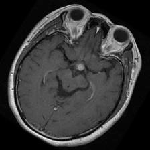

In [38]:
# getting image to test output
im = load_img(path, target_size=(150, 150), color_mode="grayscale")
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
image_tensor = np.expand_dims(im, axis=0)
print(f'x reshaped: {image_tensor.shape}')

# normilzation tensor
image_tensor /= np.max(image_tensor) # ~ np.max(img_tensor)

# Display the class name
print(f"Class name of the first image: {label}")
array_to_img(im)

1/1 [==============================] - 0s 43ms/step


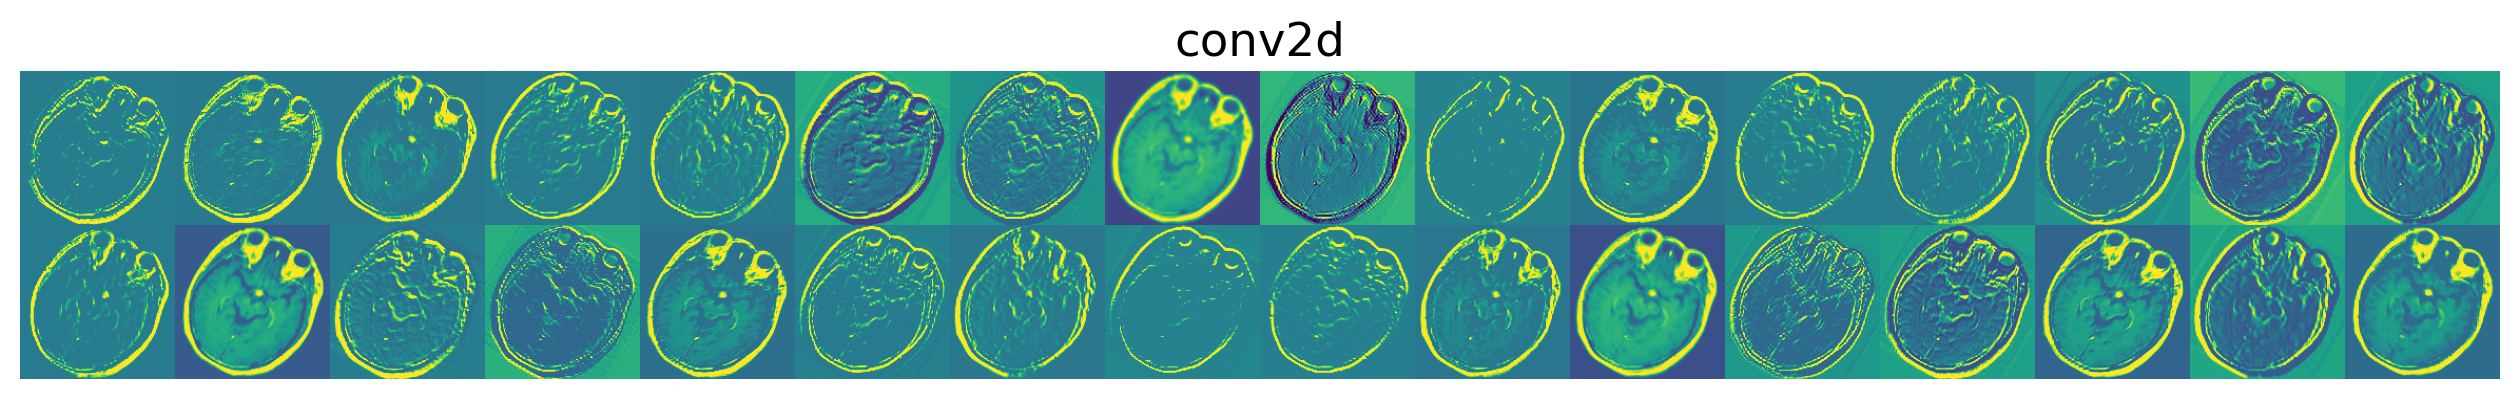

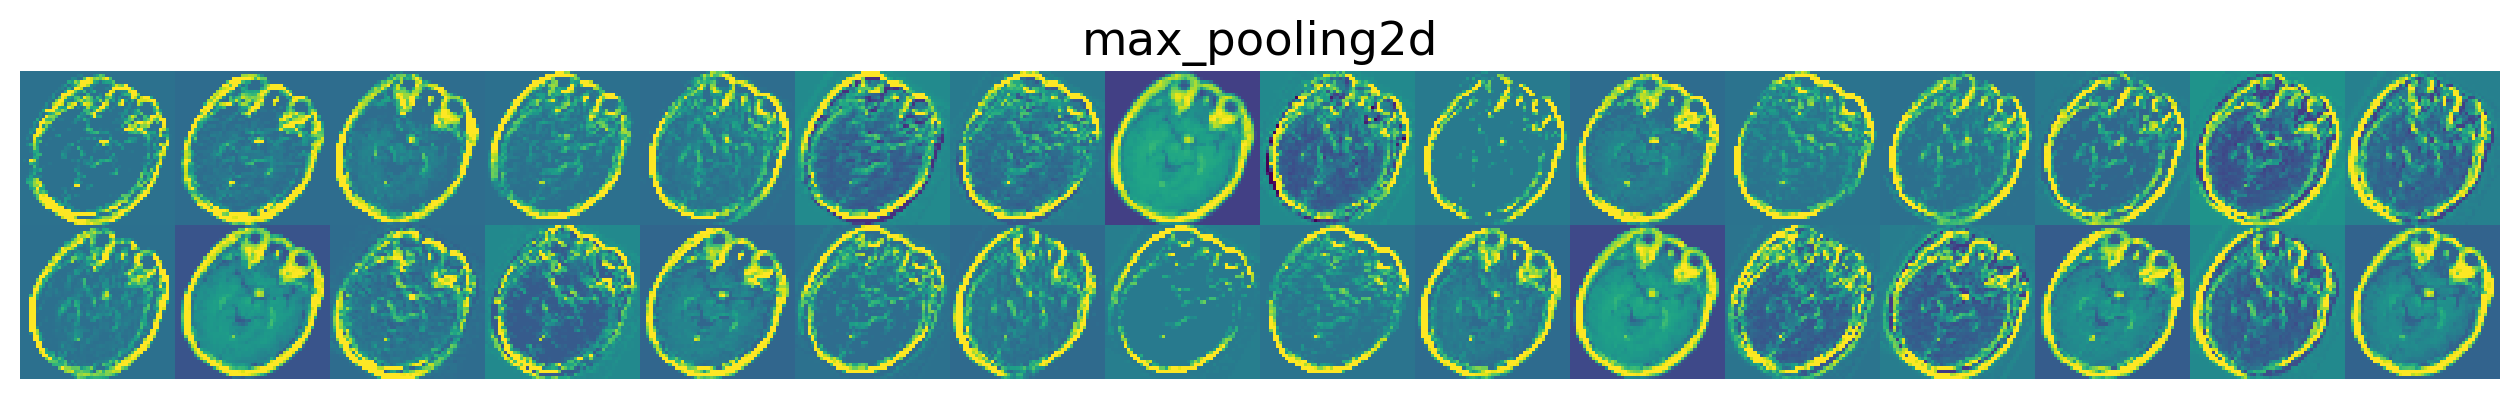

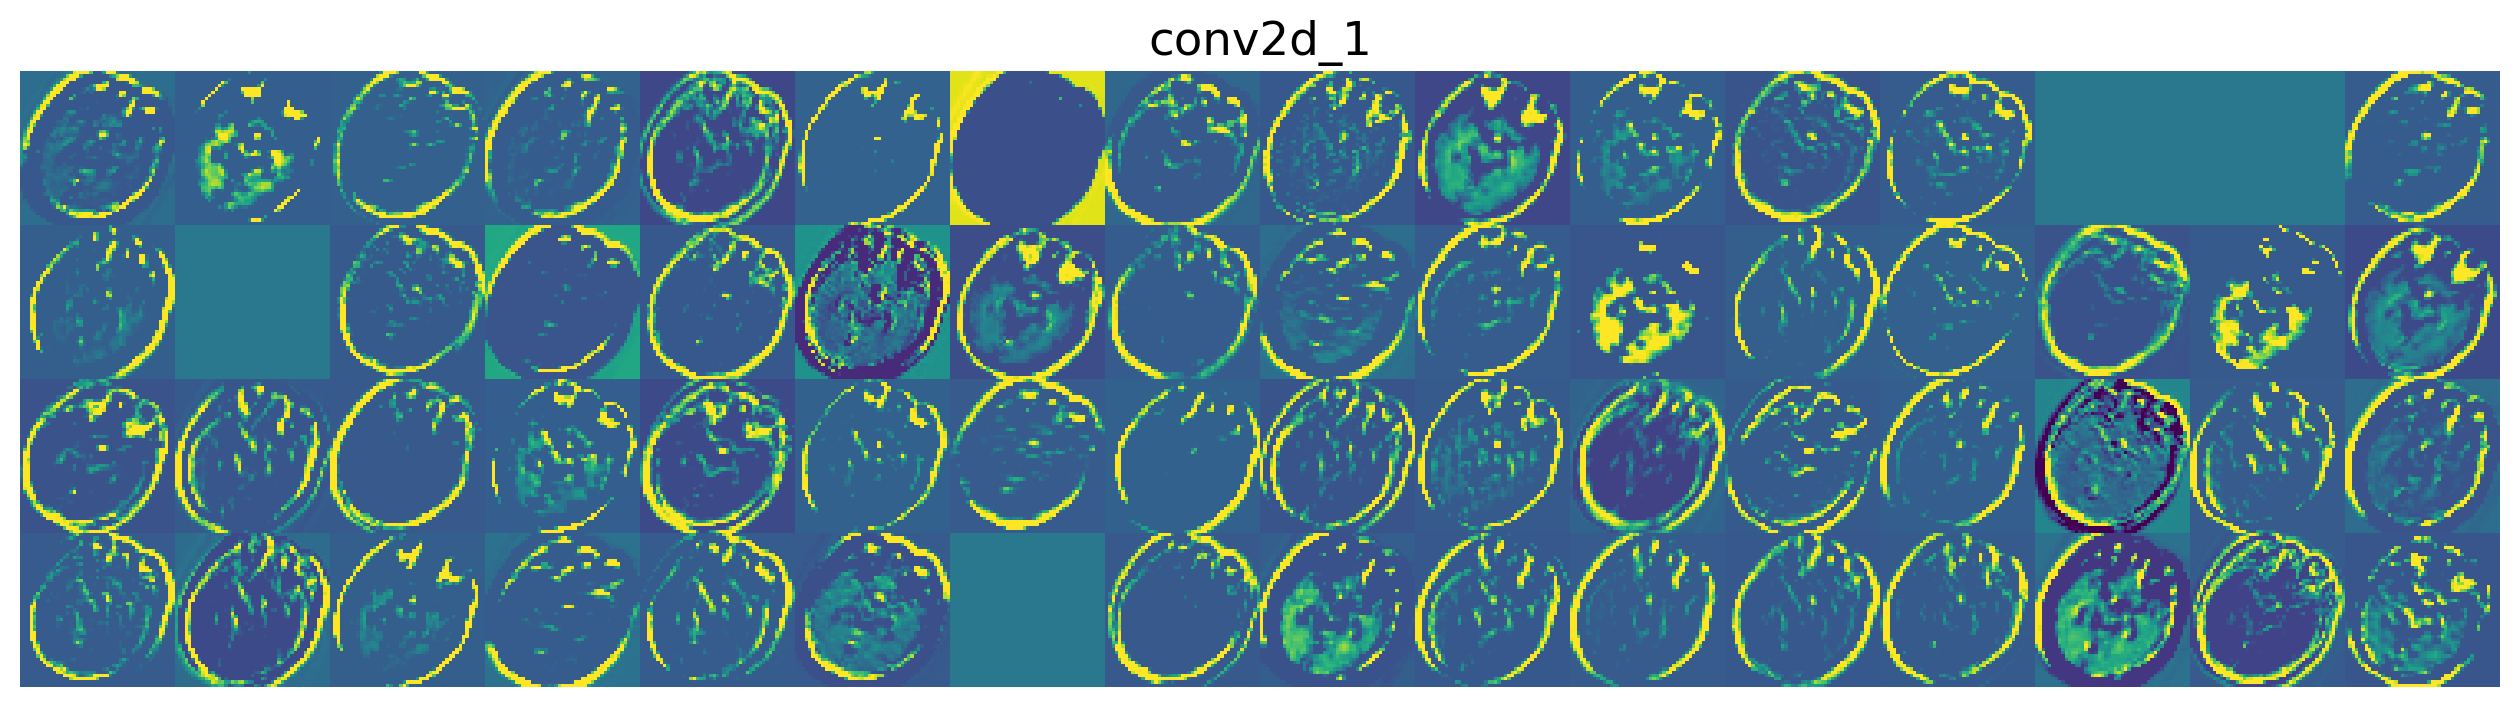

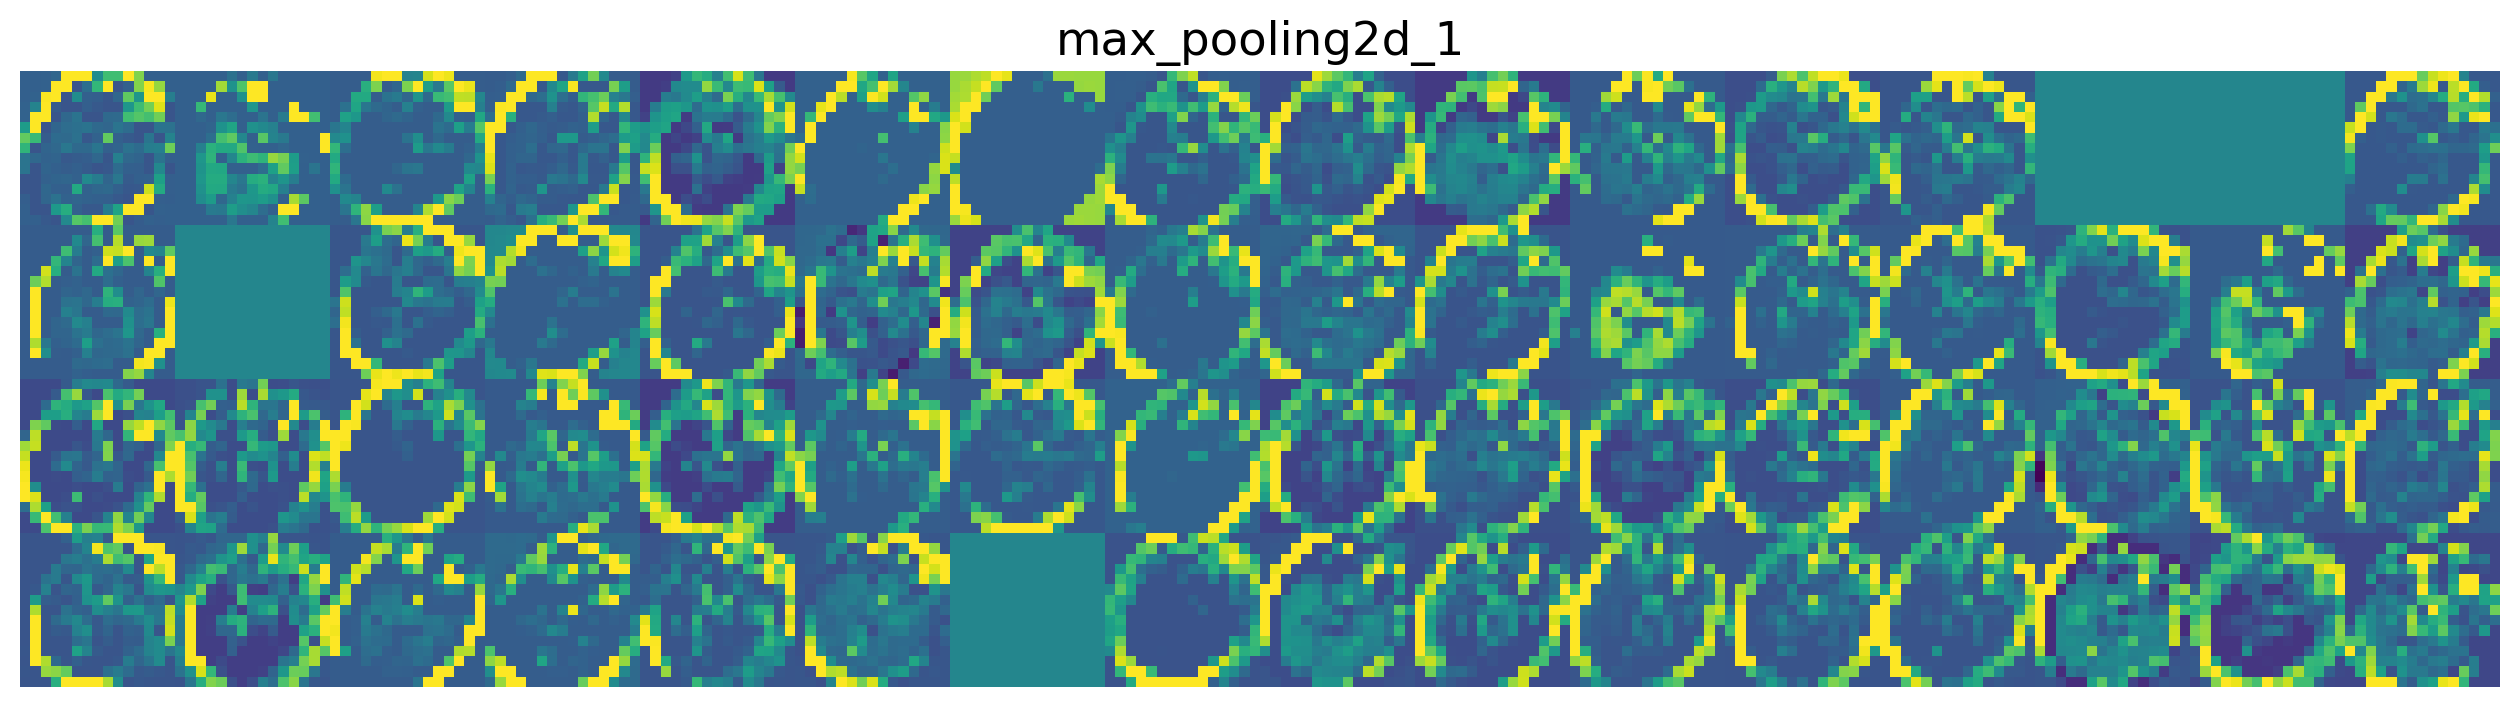

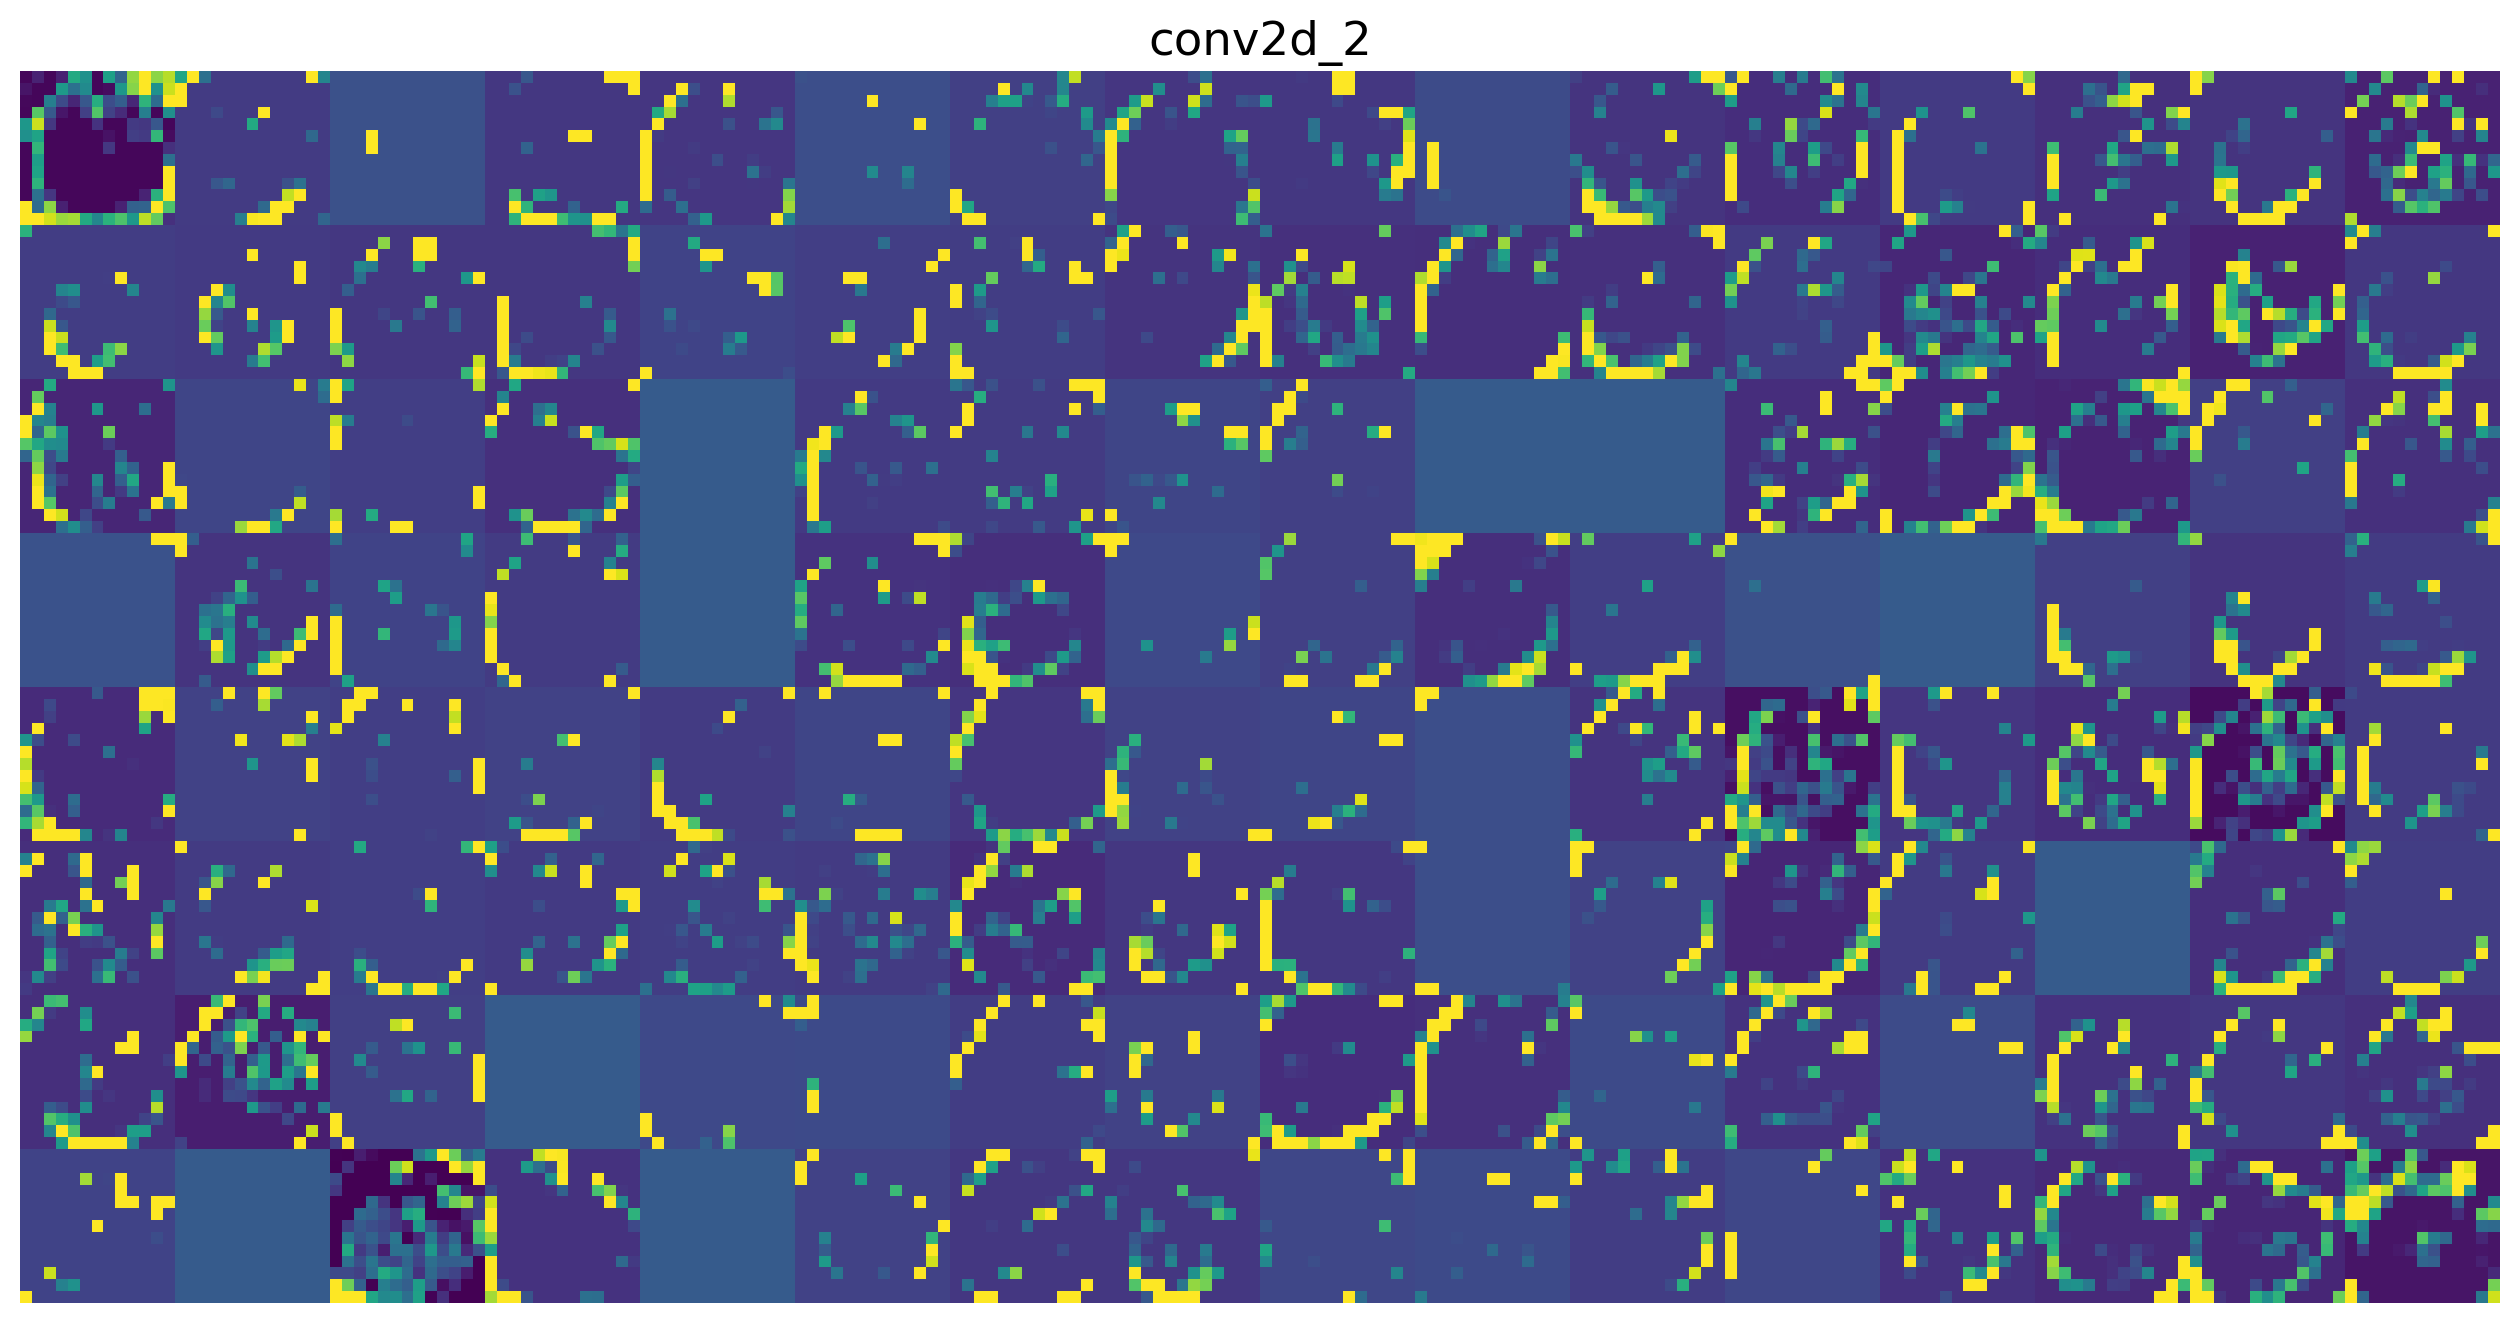

In [39]:
plot_channel_activation_maps(model=model, image=image_tensor, N=5, save=False)

1/1 [==============================] - 0s 56ms/step


C:\Users\athar\AppData\Local\Temp\ipykernel_28388\2594487134.py:26: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\athar\AppData\Local\Temp\ipykernel_28388\2594487134.py:79: RuntimeWarning: invalid value encountered in cast
  heatmap_overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
C:\Users\athar\AppData\Local\Temp\ipykernel_28388\2594487134.py:84: RuntimeWarning: invalid value encountered in cast
  contours, _ = cv2.findContours(np.uint8(255 * heatmap), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


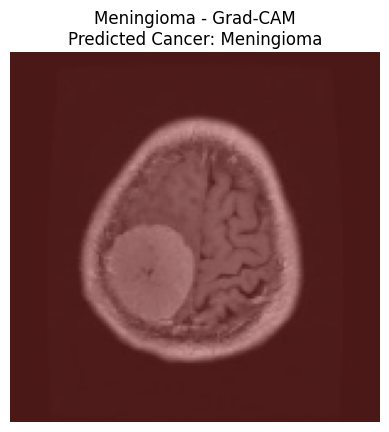

1/1 [==============================] - 0s 14ms/step


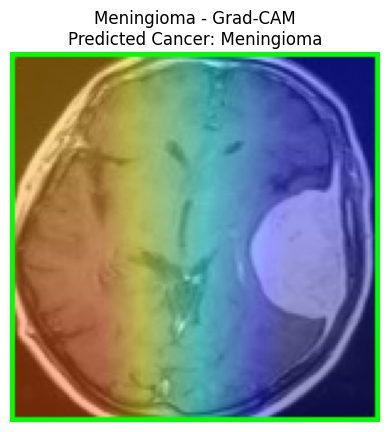

1/1 [==============================] - 0s 15ms/step


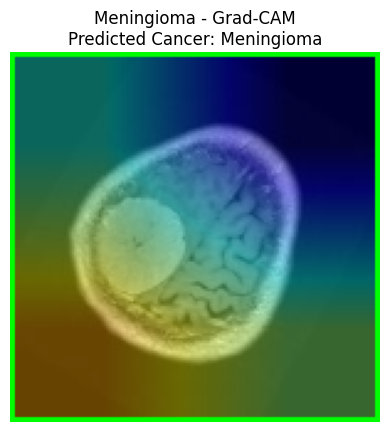

1/1 [==============================] - 0s 15ms/step


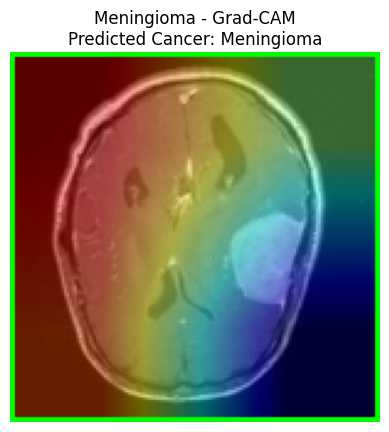

1/1 [==============================] - 0s 15ms/step


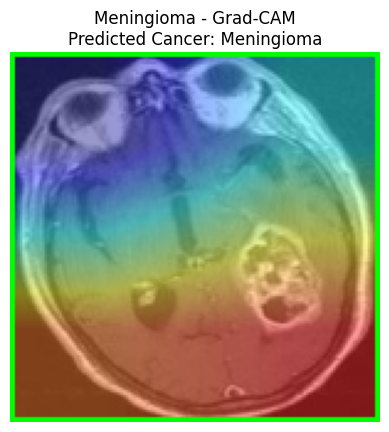

1/1 [==============================] - 0s 14ms/step


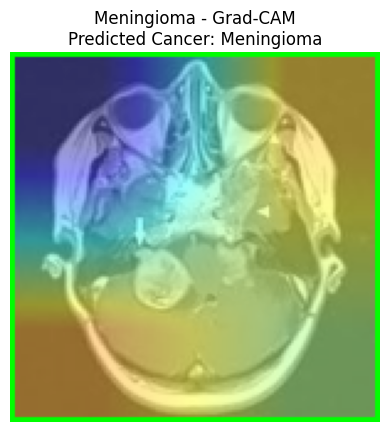

1/1 [==============================] - 0s 15ms/step


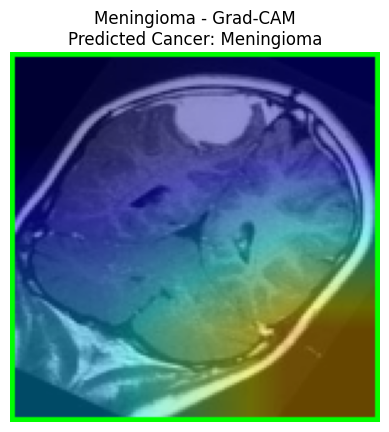

1/1 [==============================] - 0s 16ms/step


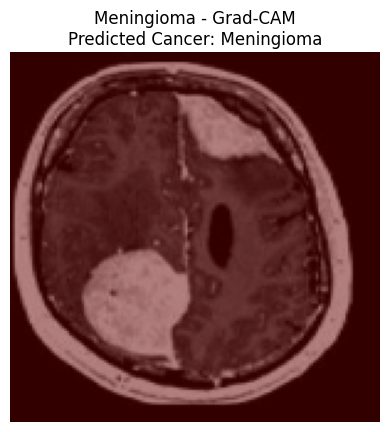

In [41]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def grad_cam(model, img_array, class_index, layer_name):
    # Create a new model that extracts the specified layer's output and the predicted class output
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Compute the gradient of the target class with respect to the specified layer's output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, class_index]

    grads = tape.gradient(class_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the feature maps by the corresponding gradients to get the class activation map
    heatmap = tf.reduce_mean(conv_outputs[0] * pooled_grads[..., tf.newaxis], axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = np.power(heatmap, 1.5)
    heatmap /= np.max(heatmap)

    return heatmap
# Load your pre-trained multi-class CNN model
model = load_model(r'C:/Users/athar/best_weights.h5')

# List of input image paths you want to visualize Grad-CAM for
image_paths = [
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_21_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_8.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_21_RO_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_68_VF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_112_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_157_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_193_RO_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\meningioma_tumor\M_219_DA_.jpg"
    # Add paths for the other 7 images here
]

# List of class names for your multi-class problem
class_names = ['Normal', 'Glioma','Meningioma','Pituitary']  # Add commas between class names

# Choose the class index for which you want to visualize Grad-CAM
class_index = 2 # Change this to the desired class index

# Loop through each image and generate Grad-CAM visualization
for img_path in image_paths:
    # Load the input image you want to visualize
    input_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    input_img = cv2.resize(input_img, (150, 150))  # Resize to the model's input size

    # Preprocess the image for the model
    img_array = np.expand_dims(input_img, axis=0)
    img_array = img_array.astype('float32') / 255.0  # Convert to float32 and normalize pixel values
    img_array = np.expand_dims(img_array, axis=-1)  # Add a channel dimension for grayscale image

    # Generate Grad-CAM for the selected class using 'conv2d_3' layer
    heatmap = grad_cam(model, img_array, class_index, 'conv2d_3')

    # Set a small epsilon value to prevent division by zero
    epsilon = 1e-8
    heatmap = np.maximum(heatmap, epsilon)

    # Normalize the heatmap values between 0 and 1
    heatmap /= np.max(heatmap)

    # Apply gamma correction to the heatmap to enhance contrast
    heatmap = np.power(heatmap, 1.5)

    # Resize the heatmap to the input image size
    heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))

    # Apply the heatmap as an overlay using the 'COLORMAP_HOT' colormap with higher alpha
    heatmap_overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    alpha = 0.6  # Adjust the alpha value for the overlay (0.6 for example)
    overlay_img = cv2.addWeighted(cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB), alpha, heatmap_overlay, 1 - alpha, 0)

    # Add contours to the overlay image to highlight the regions of classification
    contours, _ = cv2.findContours(np.uint8(255 * heatmap), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay_img, contours, -1, (0, 255, 0), 2)

    # Get the model's output for the current image
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Display the Grad-CAM visualization and the model's output for the current image
    plt.imshow(overlay_img)
    plt.title(f'{class_names[class_index]} - Grad-CAM\nPredicted Cancer: {predicted_class_name}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 54ms/step


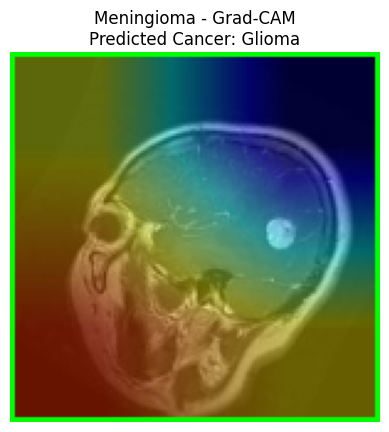

1/1 [==============================] - 0s 15ms/step


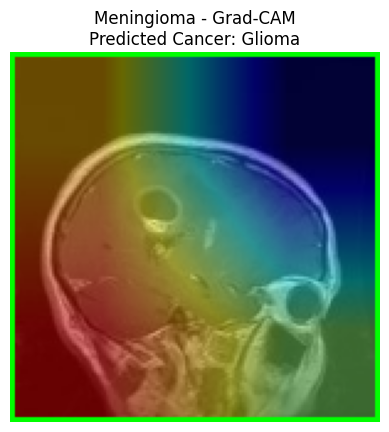

1/1 [==============================] - 0s 15ms/step


C:\Users\athar\AppData\Local\Temp\ipykernel_28388\2276956672.py:26: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\athar\AppData\Local\Temp\ipykernel_28388\2276956672.py:79: RuntimeWarning: invalid value encountered in cast
  heatmap_overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
C:\Users\athar\AppData\Local\Temp\ipykernel_28388\2276956672.py:84: RuntimeWarning: invalid value encountered in cast
  contours, _ = cv2.findContours(np.uint8(255 * heatmap), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


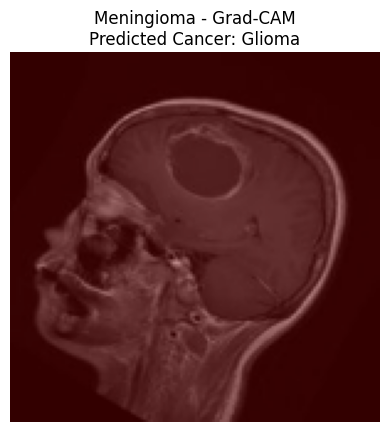

1/1 [==============================] - 0s 15ms/step


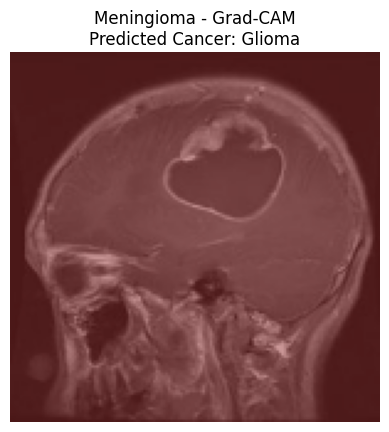

1/1 [==============================] - 0s 16ms/step


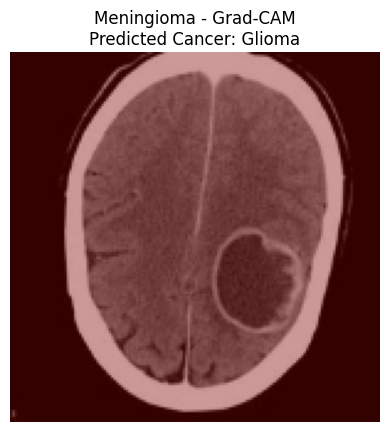

1/1 [==============================] - 0s 14ms/step


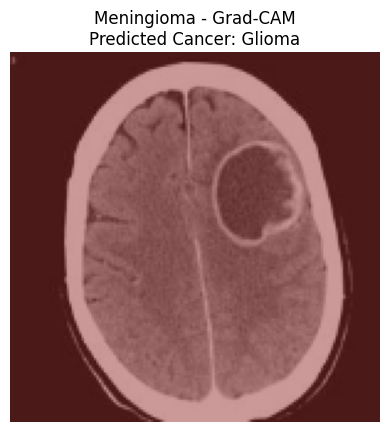

1/1 [==============================] - 0s 14ms/step


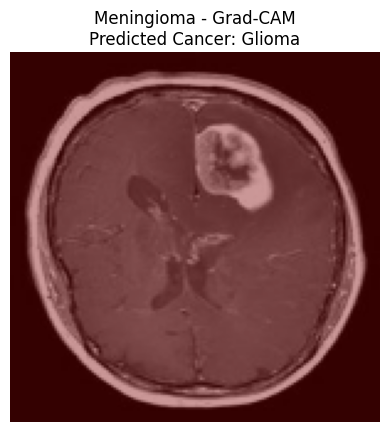

1/1 [==============================] - 0s 15ms/step


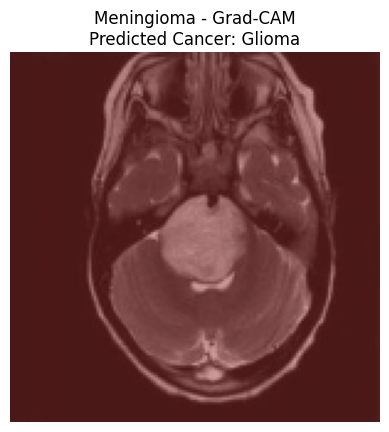

In [44]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def grad_cam(model, img_array, class_index, layer_name):
    # Create a new model that extracts the specified layer's output and the predicted class output
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Compute the gradient of the target class with respect to the specified layer's output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_output = predictions[:, class_index]

    grads = tape.gradient(class_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the feature maps by the corresponding gradients to get the class activation map
    heatmap = tf.reduce_mean(conv_outputs[0] * pooled_grads[..., tf.newaxis], axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = np.power(heatmap, 1.5)
    heatmap /= np.max(heatmap)

    return heatmap
# Load your pre-trained multi-class CNN model
model = load_model(r'C:/Users/athar/best_weights.h5')

# List of input image paths you want to visualize Grad-CAM for
image_paths = [
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_4_RO_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_11_HF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_23_RO_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_22_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_79_VF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_79_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_124_VF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_168_BR_.jpg"
    # Add paths for the other 7 images here
]

# List of class names for your multi-class problem
class_names = ['Normal', 'Glioma','Meningioma','Pituitary']  # Add commas between class names

# Choose the class index for which you want to visualize Grad-CAM
class_index = 1 # Change this to the desired class index

# Loop through each image and generate Grad-CAM visualization
for img_path in image_paths:
    # Load the input image you want to visualize
    input_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    input_img = cv2.resize(input_img, (150, 150))  # Resize to the model's input size

    # Preprocess the image for the model
    img_array = np.expand_dims(input_img, axis=0)
    img_array = img_array.astype('float32') / 255.0  # Convert to float32 and normalize pixel values
    img_array = np.expand_dims(img_array, axis=-1)  # Add a channel dimension for grayscale image

    # Generate Grad-CAM for the selected class using 'conv2d_3' layer
    heatmap = grad_cam(model, img_array, class_index, 'conv2d_3')

    # Set a small epsilon value to prevent division by zero
    epsilon = 1e-8
    heatmap = np.maximum(heatmap, epsilon)

    # Normalize the heatmap values between 0 and 1
    heatmap /= np.max(heatmap)

    # Apply gamma correction to the heatmap to enhance contrast
    heatmap = np.power(heatmap, 1.5)

    # Resize the heatmap to the input image size
    heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))

    # Apply the heatmap as an overlay using the 'COLORMAP_HOT' colormap with higher alpha
    heatmap_overlay = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    alpha = 0.6  # Adjust the alpha value for the overlay (0.6 for example)
    overlay_img = cv2.addWeighted(cv2.cvtColor(input_img, cv2.COLOR_GRAY2RGB), alpha, heatmap_overlay, 1 - alpha, 0)

    # Add contours to the overlay image to highlight the regions of classification
    contours, _ = cv2.findContours(np.uint8(255 * heatmap), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay_img, contours, -1, (0, 255, 0), 2)

    # Get the model's output for the current image
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Display the Grad-CAM visualization and the model's output for the current image
    plt.imshow(overlay_img)
    plt.title(f'{class_names[class_index]} - Grad-CAM\nPredicted Cancer: {predicted_class_name}')
    plt.axis('off')
    plt.show()

In [49]:
!pip install tf-keras-vis

                                              0.0/52.1 kB ? eta -:--:--
     ---------------------------------------- 52.1/52.1 kB 2.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore

# Load your pre-trained multi-class CNN model
model = load_model(r'C:/Users/athar/best_weights.h5')

# List of input image paths you want to visualize Grad-CAM for
image_paths = [
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_4_RO_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_11_HF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_23_RO_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_22_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_79_VF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_79_BR_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_124_VF_.jpg",
    r"D:\Code\brain_tumor\Data\Tumor\glioma_tumor\G_168_BR_.jpg"
    # Add paths for the other 7 images here
]

# List of class names for your multi-class problem
class_names = ['Normal', 'Glioma','Meningioma','Pituitary']  # Add commas between class names

# Choose the class index for which you want to visualize Grad-CAM
class_index = 2  # Change this to the desired class index

# Loop through each image and generate Grad-CAM visualization
for img_path in image_paths:
    # Load the input image you want to visualize
    input_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    input_img = cv2.resize(input_img, (150, 150))  # Resize to the model's input size

    # Preprocess the image for the model
    img_array = np.expand_dims(input_img, axis=0)
    img_array = img_array.astype('float32') / 255.0  # Convert to float32 and normalize pixel values
    img_array = np.expand_dims(img_array, axis=-1)  # Add a channel dimension for grayscale image

    # Create Grad-CAM visualization object
    gradcam = Gradcam(model, model_modifier=lambda x: x)

    # Generate Grad-CAM for the selected class
    heatmap = gradcam(CategoricalScore(class_index), img_array)

    # Normalize the heatmap values between 0 and 1
    heatmap /= np.max(heatmap)

    # Resize the heatmap to the input image size
    heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))

    # Convert the heatmap to 3-channel image with blue channel containing the heatmap
    heatmap_img = np.zeros((input_img.shape[0], input_img.shape[1], 3), dtype=np.uint8)
    heatmap_img[:, :, 0] = (heatmap * 255).astype(np.uint8)

    # Blend the heatmap with the original grayscale image
    alpha = 0.7  # Adjust the alpha value for the overlay (0.7 for example)
    blended_img = cv2.addWeighted(cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR), alpha, heatmap_img, 1 - alpha, 0)

    # Get the model's prediction for the current image
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Display the Grad-CAM visualization for the current image
    plt.imshow(blended_img)
    plt.title(f'{class_names[class_index]} - Grad-CAM\nPredicted Cancer: {predicted_class_name}')
    plt.axis('off')
    plt.show()


C:\Users\athar\AppData\Local\Temp\ipykernel_28388\3530887387.py:49: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\athar\AppData\Local\Temp\ipykernel_28388\3530887387.py:56: RuntimeWarning: invalid value encountered in cast
  heatmap_img[:, :, 0] = (heatmap * 255).astype(np.uint8)


ValueError: could not broadcast input array from shape (150,150,150) into shape (150,150)